# Plotting 3D coordinates

This notebook contains a example use case for `molplotly` for plotting poses of different docked ligands.

Let's load some docked ligands and plot the poses

INFO:rdkit:Enabling RDKit 2021.09.4 jupyter extensions
/Users/williammccorkindale/miniconda3/envs/molplotly/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:241: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


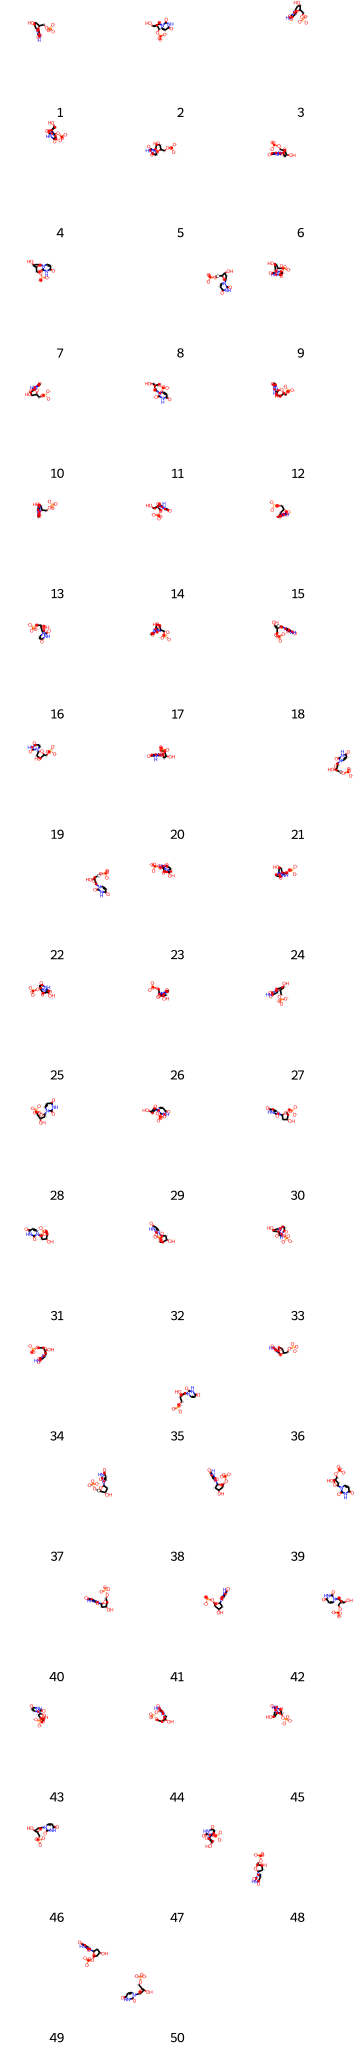

In [1]:
import pandas as pd
import plotly.express as px
import molplotly

from rdkit import Chem
from rdkit.Chem import Draw

poses=Chem.SDMolSupplier('ligand_poses.sdf')
renamed_poses=[]
for index, docked_mol in enumerate(poses):
    docked_mol.SetProp('_Name',str(index+1))
    renamed_poses.append(docked_mol)
    
img=Draw.MolsToGridImage(renamed_poses,molsPerRow=(3), subImgSize=(150,150), legends=[i.GetProp('_Name') for i in renamed_poses],useSVG=True)
img

Let's calculate the pairwise RMSD - after MCS alignment between the poses (should takes about 20s)

In [2]:
import numpy as np
from rdkit.Chem import rdFMCS

rmsd_matrix = np.empty((len(poses), len(poses)))
for i, mol in enumerate(renamed_poses):
    for j, jmol in enumerate(renamed_poses):
        # MCS identification between reference pose and target pose
        r=rdFMCS.FindMCS([mol,jmol])
        # Atom map for reference and target              
        a=mol.GetSubstructMatch(Chem.MolFromSmarts(r.smartsString))
        b=jmol.GetSubstructMatch(Chem.MolFromSmarts(r.smartsString))
        # Atom map generation     
        amap=list(zip(a,b))
        
        # distance calculation per atom pair
        distances=[]
        for atomA, atomB in amap:
            pos_A=mol.GetConformer().GetAtomPosition (atomA)
            pos_B=jmol.GetConformer().GetAtomPosition (atomB)
            coord_A=np.array((pos_A.x,pos_A.y,pos_A.z))
            coord_B=np.array ((pos_B.x,pos_B.y,pos_B.z))
            dist_numpy = np.linalg.norm(coord_A-coord_B)        
            distances.append(dist_numpy)
                         
        # This is the RMSD formula from wikipedia
        rmsd=np.sqrt(np.mean(np.square(distances))) 
        rmsd_matrix[i,j]=rmsd

rmsd_df = pd.DataFrame(rmsd_matrix,
                       index=[mol.GetProp('_Name') for mol in renamed_poses],
                       columns=[mol.GetProp('_Name') for mol in renamed_poses])

Let's cluster the poses into 5 clusters with a K-means over the RMSD matrix

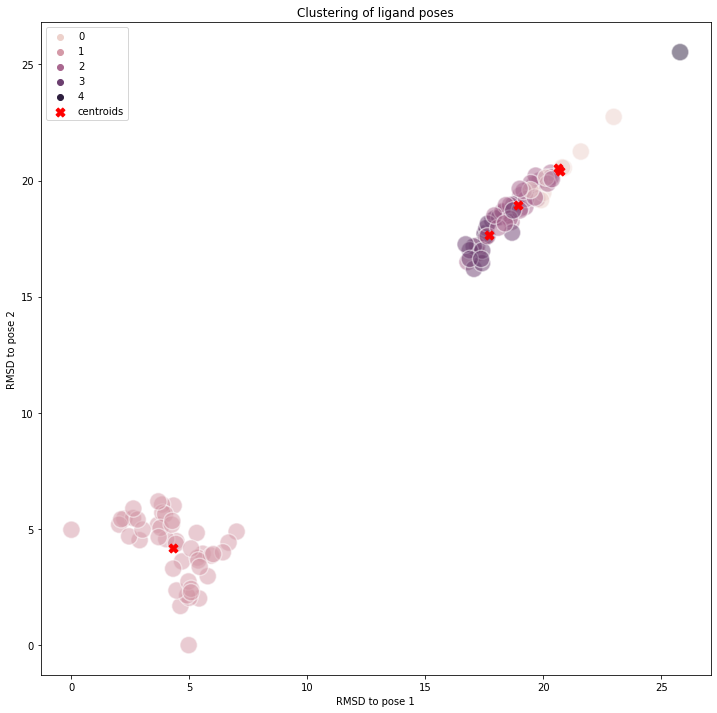

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0, ).fit(rmsd_matrix)
figure= plt.figure(figsize=(12,12))

sns.scatterplot(data=rmsd_df,
                x="1",
                y="2",
                hue=kmeans.labels_,
                alpha=0.5,
                s=300,
                )
plt.scatter(x = kmeans.cluster_centers_[:,0],
            y = kmeans.cluster_centers_[:,1], 
            marker="X",
            c="r",
            s=80,
            label="centroids")
plt.title('Clustering of ligand poses')
plt.xlabel('RMSD to pose 1')
plt.ylabel('RMSD to pose 2')
plt.legend()
plt.show()

Doing the same plot in `plotly`!

In [4]:
import plotly.graph_objects as go

rmsd_df['pose_index'] = range(1, len(renamed_poses)+1)
rmsd_df['cluster'] = kmeans.labels_
rmsd_df['cluster'] = rmsd_df['cluster'].astype(str)

scatter_fig = px.scatter(rmsd_df, 
                x="1", 
                y="2",
                color='cluster',
                hover_name='pose_index',
                width=1000,
                height=800,
                title='Clustering of ligand poses',
                labels={'1':'RMSD to pose 1',
                        '2':'RMSD to pose 2',}
                )
scatter_fig.add_trace(
        go.Scatter(
            x = kmeans.cluster_centers_[:,0],
            y = kmeans.cluster_centers_[:,1],
            mode='markers',
            marker=dict(color="red", 
                        symbol='x',
                        size=10),
            showlegend=False,))
scatter_fig.update_traces(marker=dict(size=12))


Adding `molplotly` and specifying `mol_col` allows the 3D coordinates of the pose to be shown on mouseover!

Unfortunately there are issues with handling additional non-molecular traces in `molplotly` so we'll have to re-create the scatter plot without the centroids.

In [5]:
import molplotly

rmsd_df['mol'] = renamed_poses 

scatter_fig = px.scatter(rmsd_df, 
                x="1", 
                y="2",
                color='cluster',
                hover_name='pose_index',
                width=1000,
                height=800,
                title='Clustering of ligand poses',
                labels={'1':'RMSD to pose 1',
                        '2':'RMSD to pose 2',}
                )

scatter_fig.update_traces(marker=dict(size=12))

app_clusters = molplotly.add_molecules(
    fig=scatter_fig,
    df=rmsd_df,
    mol_col="mol",
    color_col='cluster',
    title_col="pose_index",
    caption_transform={'pose_index': lambda x: f'Pose {x}'},
)

app_clusters.run_server(mode="inline", port=8704, height=850)


Using `smiles_mol` reverts to the default 2D molecule representation

In [6]:
rmsd_df['SMILES'] = [Chem.MolToSmiles(mol) for mol in renamed_poses]

app_clusters = molplotly.add_molecules(
    fig=scatter_fig,
    df=rmsd_df,
    smiles_col="SMILES",
    color_col='cluster',
    title_col="pose_index",
    caption_transform={'pose_index': lambda x: f'Pose {x}'},
    show_coords=True,
)

app_clusters.run_server(mode="inline", port=8705, height=850)

